### Preparation

In [1]:
import numpy as np
from sympy import *
import warnings
from scipy.linalg import solve_continuous_lyapunov
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)
init_printing(use_unicode=True)

def num_sym(p: int) -> int:
    return int(p * (p + 1) / 2)

def create_A_Sigma_sympy(cov: Matrix, p: int) -> Matrix:
    row_num = num_sym(p=p)
    col_num = int(p * p)
    A_Sigma = MatrixSymbol("A", row_num, col_num).as_mutable()
    for l in range(p):
        for k in range(l+1):
            for i in range(p):
                for j in range(p):
                    if (j != k) & (j != l):
                        A_Sigma[(k * p) + (l - num_sym(p=k)), i * p + j] = 0
                    elif (j == k) & (k != l):
                        A_Sigma[(k * p) + (l - num_sym(p=k)), i * p + j] = cov[l, i]
                    elif (j == l) & (l != k):
                        A_Sigma[(k * p) + (l - num_sym(p=k)), i * p + j] = cov[k, i]
                    elif (j == k) & (j == l):
                        A_Sigma[(k * p) + (l - num_sym(p=k)), i * p + j] = 2 * cov[j, i]
    return A_Sigma

def create_A_sympy(A_Sigma: Matrix, mean: Matrix, p: int) -> Matrix:
    identity = mean[0] * eye(p)
    for i in range(1, p):
        identity = Matrix.hstack(identity, mean[i] * eye(p))
    return Matrix.vstack(A_Sigma, identity)

def simulate_M(seed: int, p: int) -> Array:
    np.random.seed(seed=seed)
    normal_matrix = np.random.normal(0, 1, (p, p))
    for i in range(p): # adjust diagonal entries s.t. M stable
        normal_matrix[i, i] = - np.sum(np.abs(normal_matrix[i, :]))
    return normal_matrix

def create_A_Sigma(cov: Array, p: int) -> Array:
    row_num = num_sym(p=p)
    col_num = int(p * p)
    A_Sigma = np.empty(shape=(row_num, col_num), dtype=float)
    for l in range(p):
        for k in range(l+1):
            for i in range(p):
                for j in range(p):
                    if (j != k) & (j != l):
                        A_Sigma[(k * p) + (l - num_sym(p=k)), i * p + j] = 0
                    elif (j == k) & (k != l):
                        A_Sigma[(k * p) + (l - num_sym(p=k)), i * p + j] = cov[l, i]
                    elif (j == l) & (l != k):
                        A_Sigma[(k * p) + (l - num_sym(p=k)), i * p + j] = cov[k, i]
                    elif (j == k) & (j == l):
                        A_Sigma[(k * p) + (l - num_sym(p=k)), i * p + j] = 2 * cov[j, i]
    return A_Sigma

def create_A(A_Sigma: Array, mean: Array, p: int) -> Array:
    identity = mean[0] * eye(p)
    for i in range(1, p):
        identity = np.hstack((identity, mean[i] * eye(p)))
    return np.vstack((A_Sigma, identity))

num_exp = 1000 # number of true matrices per case
num_sim = 1000 # number of simulations per true matrix

index_intervention = 1
b = 10

### 2 nodes
$\text{rank}(A) = 4 = p^2$

$\frac{p(p+3)}{2} = 5$

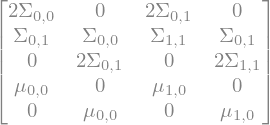

In [2]:
p = 2
Sigma = MatrixSymbol("Sigma", p, p).as_mutable()
cov = Matrix(p, p, lambda i, j: Sigma[min(i,j),max(i,j)])
mean = MatrixSymbol("mu", p, 1).as_mutable()
A_Sigma = create_A_Sigma_sympy(cov=cov, p=p)
A = create_A_sympy(A_Sigma=A_Sigma, mean=mean, p=p)
A

In [3]:
A.rank()

In [4]:
A_Sigma.rank()

### 3 nodes
$\text{rank}(A) = 8 = p^2 - 1$

$\frac{p(p+3)}{2} = 9$

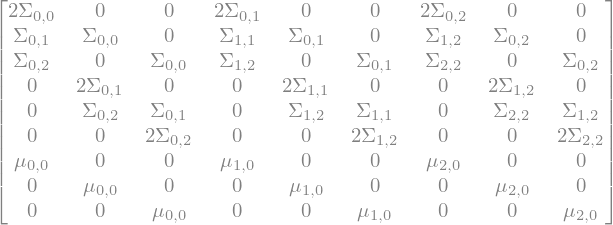

In [5]:
p = 3
Sigma = MatrixSymbol("Sigma", p, p).as_mutable()
cov = Matrix(p, p, lambda i, j: Sigma[min(i,j),max(i,j)])
mean = MatrixSymbol("mu", p, 1).as_mutable()
A_Sigma = create_A_Sigma_sympy(cov=cov, p=p)
A = create_A_sympy(A_Sigma=A_Sigma, mean=mean, p=p)
A

In [6]:
A.rank()

In [7]:
A_Sigma.rank()

### Transform A such that rank condition becomes apparent

In [27]:
p = 3
Sigma = MatrixSymbol("Sigma", p, p).as_mutable()
cov = Matrix(p, p, lambda i, j: Sigma[min(i,j),max(i,j)])
mean = MatrixSymbol("mu", p, 1).as_mutable()
A_Sigma = create_A_Sigma_sympy(cov=cov, p=p)
A = create_A_sympy(A_Sigma=A_Sigma, mean=mean, p=p)

# dismiss factors
A[0, :] = A[0, :] / 2
A[3, :] = A[3, :] / 2
A[5, :] = A[5, :] / 2

# set first column to 0
A[0, :] = A[0, :] - (A[0, 0] / A[6, 0]) * A[6, :]
A[1, :] = A[1, :] - (A[1, 0] / A[6, 0]) * A[6, :]
A[2, :] = A[2, :] - (A[2, 0] / A[6, 0]) * A[6, :]
# set second column to 0
A[1, :] = A[1, :] - (A[1, 1] / A[7, 1]) * A[7, :]
A[3, :] = A[3, :] - (A[3, 1] / A[7, 1]) * A[7, :]
A[4, :] = A[4, :] - (A[4, 1] / A[7, 1]) * A[7, :]
# set third column to 0
A[2, :] = A[2, :] - (A[2, 2] / A[8, 2]) * A[8, :]
A[4, :] = A[4, :] - (A[4, 2] / A[8, 2]) * A[8, :]
A[5, :] = A[5, :] - (A[5, 2] / A[8, 2]) * A[8, :]

# set fourth column to 0
A[1, :] = A[1, :] - (A[1, 3] / A[0, 3]) * A[0, :]
A[2, :] = A[2, :] - (A[2, 3] / A[0, 3]) * A[0, :]
A[6, :] = A[6, :] - (A[6, 3] / A[0, 3]) * A[0, :]
# set fifth column to 0
A[1, :] = A[1, :] - (A[1, 4] / A[3, 4]) * A[3, :]
A[4, :] = A[4, :] - (A[4, 4] / A[3, 4]) * A[3, :]
A[7, :] = A[7, :] - (A[7, 4] / A[3, 4]) * A[3, :]
# set sixth column to 0
A[2, :] = A[2, :] - (A[2, 5] / A[5, 5]) * A[5, :]
A[4, :] = A[4, :] - (A[4, 5] / A[5, 5]) * A[5, :]
A[8, :] = A[8, :] - (A[8, 5] / A[5, 5]) * A[5, :]

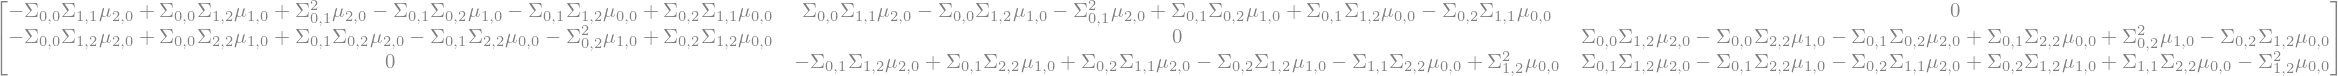

In [29]:
new_A_3 = A[[1, 2, 4], 6:9] # rank = 2
new_A_3 = simplify(new_A_3).as_mutable()
new_A_3[:, 0] = new_A_3[:, 0] * (cov[0,0]*mean[1,0] - cov[0,1]*mean[0,0])
new_A_3[:, 1] = new_A_3[:, 1] * (cov[1,0]*mean[1,0] - cov[1,1]*mean[0,0])
new_A_3[:, 2] = new_A_3[:, 2] * (cov[2,0]*mean[1,0] - cov[2,1]*mean[0,0])
new_A_3

### 4 nodes
$\text{rank}(A) = 13 = p^2 - 3$

$\frac{p(p+3)}{2} = 14$

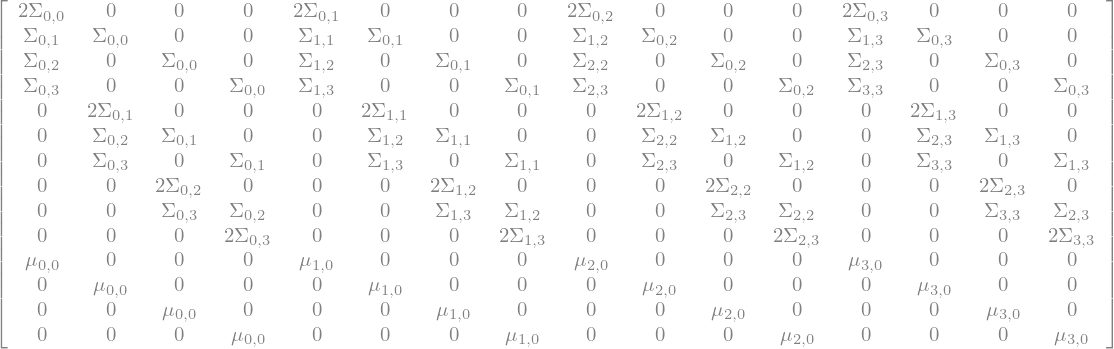

In [10]:
p = 4
Sigma = MatrixSymbol("Sigma", p, p).as_mutable()
cov = Matrix(p, p, lambda i, j: Sigma[min(i,j),max(i,j)])
mean = MatrixSymbol("mu", p, 1).as_mutable()
A_Sigma = create_A_Sigma_sympy(cov=cov, p=p)
A = create_A_sympy(A_Sigma=A_Sigma, mean=mean, p=p)
A

In [11]:
p = 4
offset = 240

C = 2 * np.eye(p)
unit_v = np.eye(p)[:, index_intervention]

rank_4 = np.empty(shape=(num_exp), dtype=object)

for seed in range(offset, num_exp + offset):
    true_M = simulate_M(seed=seed, p=p)

    true_cov = solve_continuous_lyapunov(a=true_M, q=-C)
    true_mean = (b * np.linalg.inv(a=true_M)).dot(unit_v)

    obs = np.random.multivariate_normal(mean = true_mean, cov = true_cov, size = num_sim)
    emp_cov = np.cov(obs, rowvar=False)
    emp_mean = np.mean(obs, axis=0)

    emp_A_Sigma = create_A_Sigma(cov=emp_cov, p=p)
    emp_A = create_A(A_Sigma=emp_A_Sigma, mean=emp_mean, p=p)
    emp_A = np.float64(emp_A)

    rank_4[seed - offset] = np.linalg.matrix_rank(emp_A)

print(int(np.min(rank_4)))
print(int(np.max(rank_4)))
print(num_sym(p) + p)

13
13
14


### Transform A such that rank becomes apparent

In [12]:
p = 4
Sigma = MatrixSymbol("Sigma", p, p).as_mutable()
cov = Matrix(p, p, lambda i, j: Sigma[min(i,j),max(i,j)])
mean = MatrixSymbol("mu", p, 1).as_mutable()
A_Sigma = create_A_Sigma_sympy(cov=cov, p=p)
A = create_A_sympy(A_Sigma=A_Sigma, mean=mean, p=p)

# dismiss factors
A[0, :] = A[0, :] / 2
A[4, :] = A[4, :] / 2
A[7, :] = A[7, :] / 2
A[9, :] = A[9, :] / 2

# set first column to 0
A[0, :] = A[0, :] - (A[0, 0] / A[10, 0]) * A[10, :]
A[1, :] = A[1, :] - (A[1, 0] / A[10, 0]) * A[10, :]
A[2, :] = A[2, :] - (A[2, 0] / A[10, 0]) * A[10, :]
A[3, :] = A[3, :] - (A[3, 0] / A[10, 0]) * A[10, :]
# set second column to 0
A[1, :] = A[1, :] - (A[1, 1] / A[11, 1]) * A[11, :]
A[4, :] = A[4, :] - (A[4, 1] / A[11, 1]) * A[11, :]
A[5, :] = A[5, :] - (A[5, 1] / A[11, 1]) * A[11, :]
A[6, :] = A[6, :] - (A[6, 1] / A[11, 1]) * A[11, :]
# set third column to 0
A[2, :] = A[2, :] - (A[2, 2] / A[12, 2]) * A[12, :]
A[5, :] = A[5, :] - (A[5, 2] / A[12, 2]) * A[12, :]
A[7, :] = A[7, :] - (A[7, 2] / A[12, 2]) * A[12, :]
A[8, :] = A[8, :] - (A[8, 2] / A[12, 2]) * A[12, :]
# set fourth column to 0
A[3, :] = A[3, :] - (A[3, 3] / A[13, 3]) * A[13, :]
A[6, :] = A[6, :] - (A[6, 3] / A[13, 3]) * A[13, :]
A[8, :] = A[8, :] - (A[8, 3] / A[13, 3]) * A[13, :]
A[9, :] = A[9, :] - (A[9, 3] / A[13, 3]) * A[13, :]

# set fifth column to 0
A[1, :] = A[1, :] - (A[1, 4] / A[0, 4]) * A[0, :]
A[2, :] = A[2, :] - (A[2, 4] / A[0, 4]) * A[0, :]
A[3, :] = A[3, :] - (A[3, 4] / A[0, 4]) * A[0, :]
A[10, :] = A[10, :] - (A[10, 4] / A[0, 4]) * A[0, :]
# set sixth column to 0
A[1, :] = A[1, :] - (A[1, 5] / A[4, 5]) * A[4, :]
A[5, :] = A[5, :] - (A[5, 5] / A[4, 5]) * A[4, :]
A[6, :] = A[6, :] - (A[6, 5] / A[4, 5]) * A[4, :]
A[11, :] = A[11, :] - (A[11, 5] / A[4, 5]) * A[4, :]
# set seventh column to 0
A[2, :] = A[2, :] - (A[2, 6] / A[7, 6]) * A[7, :]
A[5, :] = A[5, :] - (A[5, 6] / A[7, 6]) * A[7, :]
A[8, :] = A[8, :] - (A[8, 6] / A[7, 6]) * A[7, :]
A[12, :] = A[12, :] - (A[12, 6] / A[7, 6]) * A[7, :]
# set eigth column to 0
A[3, :] = A[3, :] - (A[3, 7] / A[9, 7]) * A[9, :]
A[6, :] = A[6, :] - (A[6, 7] / A[9, 7]) * A[9, :]
A[8, :] = A[8, :] - (A[8, 7] / A[9, 7]) * A[9, :]
A[13, :] = A[13, :] - (A[13, 7] / A[9, 7]) * A[9, :]

In [13]:
# set rows 11, 12, 13, 14 to zero
A[:, 8] = A[:, 8] - (A[10, 8] / A[10, 0]) * A[:, 0]
A[:, 9] = A[:, 9] - (A[11, 9] / A[11, 1]) * A[:, 1]
A[:, 10] = A[:, 10] - (A[12, 10] / A[12, 2]) * A[:, 2]
A[:, 11] = A[:, 11] - (A[13, 11] / A[13, 3]) * A[:, 3]

A[:, 12] = A[:, 12] - (A[10, 12] / A[10, 0]) * A[:, 0]
A[:, 13] = A[:, 13] - (A[11, 13] / A[11, 1]) * A[:, 1]
A[:, 14] = A[:, 14] - (A[12, 14] / A[12, 2]) * A[:, 2]
A[:, 15] = A[:, 15] - (A[13, 15] / A[13, 3]) * A[:, 3]

# set rows 1, 5, 8, 10 to zero
A[:, 8] = A[:, 8] - (A[0, 8] / A[0, 4]) * A[:, 4]
A[:, 9] = A[:, 9] - (A[4, 9] / A[4, 5]) * A[:, 5]
A[:, 10] = A[:, 10] - (A[7, 10] / A[7, 6]) * A[:, 6]
A[:, 11] = A[:, 11] - (A[9, 11] / A[9, 7]) * A[:, 7]

A[:, 12] = A[:, 12] - (A[0, 12] / A[0, 4]) * A[:, 4]
A[:, 13] = A[:, 13] - (A[4, 13] / A[4, 5]) * A[:, 5]
A[:, 14] = A[:, 14] - (A[7, 14] / A[7, 6]) * A[:, 6]
A[:, 15] = A[:, 15] - (A[9, 15] / A[9, 7]) * A[:, 7]

A = simplify(A)
new_A_4 = A[[1, 2, 3, 5, 6, 8], 8:]

In [14]:
new_A_4 = new_A_4.as_mutable()

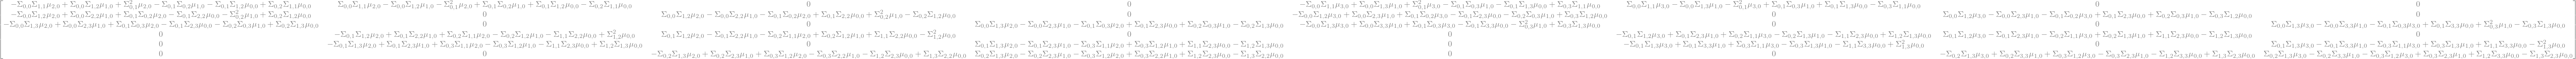

In [15]:
new_A_4[:, 0] = new_A_4[:, 0] * (cov[0,0]*mean[1,0] - cov[0,1]*mean[0,0])
new_A_4[:, 4] = new_A_4[:, 4] * (cov[0,0]*mean[1,0] - cov[0,1]*mean[0,0])
new_A_4[:, 1] = new_A_4[:, 1] * (cov[1,0]*mean[1,0] - cov[1,1]*mean[0,0])
new_A_4[:, 5] = new_A_4[:, 5] * (cov[1,0]*mean[1,0] - cov[1,1]*mean[0,0])
new_A_4[:, 2] = new_A_4[:, 2] * (cov[2,0]*mean[1,0] - cov[2,1]*mean[0,0])
new_A_4[:, 6] = new_A_4[:, 6] * (cov[2,0]*mean[1,0] - cov[2,1]*mean[0,0])
new_A_4[:, 3] = new_A_4[:, 3] * (cov[3,0]*mean[1,0] - cov[3,1]*mean[0,0])
new_A_4[:, 7] = new_A_4[:, 7] * (cov[3,0]*mean[1,0] - cov[3,1]*mean[0,0])
new_A_4

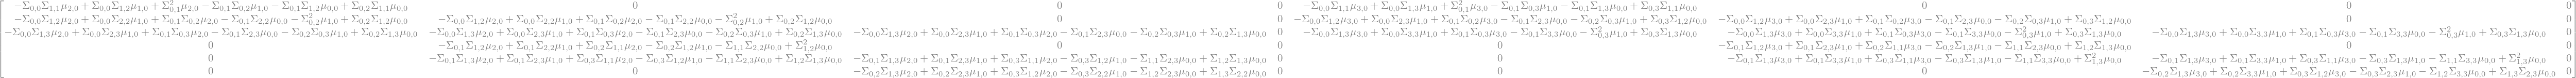

In [16]:
new_A_4[:, 1] = new_A_4[:, 1] + new_A_4[:, 0]
new_A_4[:, 2] = new_A_4[:, 2] + new_A_4[:, 1]
new_A_4[:, 3] = new_A_4[:, 3] + new_A_4[:, 2]

new_A_4[:, 5] = new_A_4[:, 5] + new_A_4[:, 4]
new_A_4[:, 6] = new_A_4[:, 6] + new_A_4[:, 5]
new_A_4[:, 7] = new_A_4[:, 7] + new_A_4[:, 6]
new_A_4

### 5 nodes
$\text{rank}(A) = 19 = p^2 - 6$

$\frac{p(p+3)}{2} = 20$

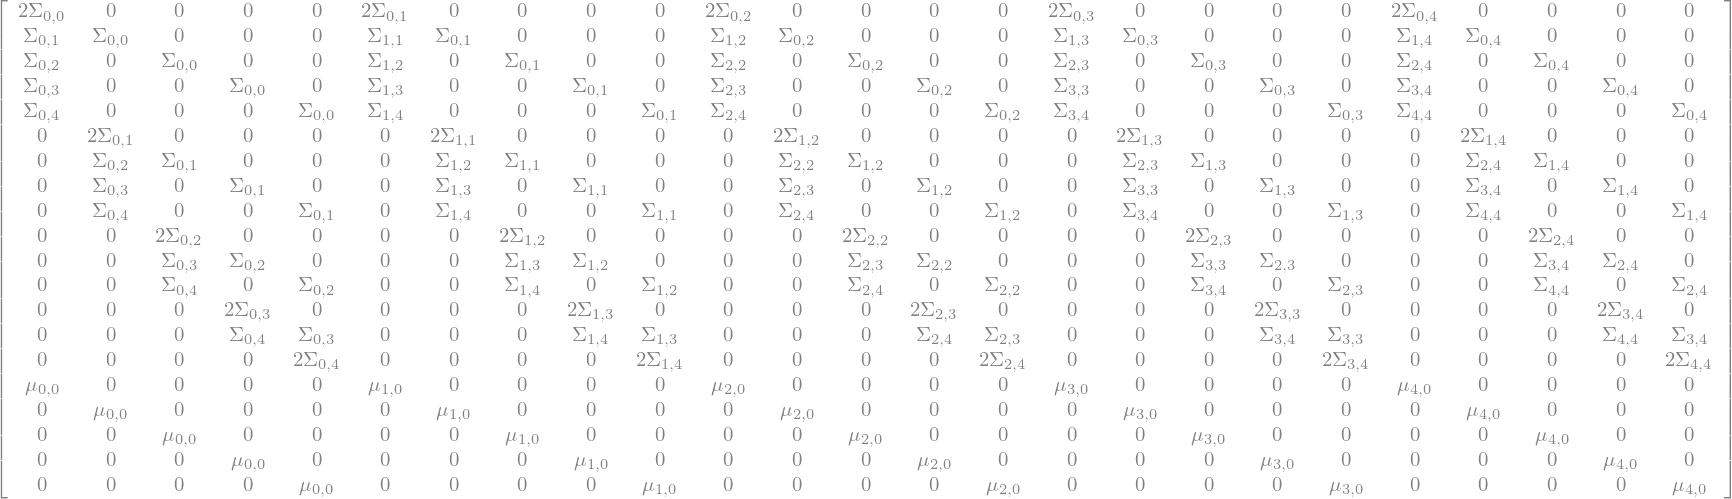

In [17]:
p = 5
Sigma = MatrixSymbol("Sigma", p, p).as_mutable()
cov = Matrix(p, p, lambda i, j: Sigma[min(i,j),max(i,j)])
mean = MatrixSymbol("mu", p, 1).as_mutable()
A_Sigma = create_A_Sigma_sympy(cov=cov, p=p)
A = create_A_sympy(A_Sigma=A_Sigma, mean=mean, p=p)
A

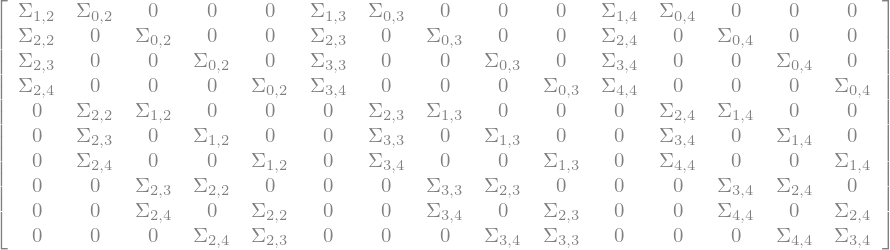

In [18]:
new_A_5 = A[[1, 2, 3, 4, 6, 7, 8, 10, 11, 13], 10:]
new_A_5

In [19]:
p = 5
offset = 2409

C = 2 * np.eye(p)
unit_v = np.eye(p)[:, index_intervention]

rank_5 = np.empty(shape=(num_exp), dtype=object)

for seed in range(offset, num_exp + offset):
    true_M = simulate_M(seed=seed, p=p)

    true_cov = solve_continuous_lyapunov(a=true_M, q=-C)
    true_mean = (b * np.linalg.inv(a=true_M)).dot(unit_v)

    obs = np.random.multivariate_normal(mean = true_mean, cov = true_cov, size = num_sim)
    emp_cov = np.cov(obs, rowvar=False)
    emp_mean = np.mean(obs, axis=0)

    emp_A_Sigma = create_A_Sigma(cov=emp_cov, p=p)
    emp_A = create_A(A_Sigma=emp_A_Sigma, mean=emp_mean, p=p)
    emp_A = np.float64(emp_A)

    rank_5[seed - offset] = np.linalg.matrix_rank(emp_A)

print(int(np.min(rank_5)))
print(int(np.max(rank_5)))
print(num_sym(p) + p)

19
19
20


### 6 nodes
$\text{rank}(A) = 26 = p^2 - 10$

$\frac{p(p+3)}{2} = 27$

In [20]:
p = 6
Sigma = MatrixSymbol("Sigma", p, p).as_mutable()
cov = Matrix(p, p, lambda i, j: Sigma[min(i,j),max(i,j)])
mean = MatrixSymbol("mu", p, 1).as_mutable()
A_Sigma = create_A_Sigma_sympy(cov=cov, p=p)
A = create_A_sympy(A_Sigma=A_Sigma, mean=mean, p=p)
# A

In [21]:
p = 6
offset = 24090

C = 2 * np.eye(p)
unit_v = np.eye(p)[:, index_intervention]

rank_6 = np.empty(shape=(num_exp), dtype=object)

for seed in range(offset, num_exp + offset):
    true_M = simulate_M(seed=seed, p=p)

    true_cov = solve_continuous_lyapunov(a=true_M, q=-C)
    true_mean = (b * np.linalg.inv(a=true_M)).dot(unit_v)

    obs = np.random.multivariate_normal(mean = true_mean, cov = true_cov, size = num_sim)
    emp_cov = np.cov(obs, rowvar=False)
    emp_mean = np.mean(obs, axis=0)

    emp_A_Sigma = create_A_Sigma(cov=emp_cov, p=p)
    emp_A = create_A(A_Sigma=emp_A_Sigma, mean=emp_mean, p=p)
    emp_A = np.float64(emp_A)

    rank_6[seed - offset] = np.linalg.matrix_rank(emp_A)

print(int(np.min(rank_6)))
print(int(np.max(rank_6)))
print(num_sym(p) + p)

26
26
27


### 7 nodes

In [22]:
p = 7
offset = 240901

C = 2 * np.eye(p)
unit_v = np.eye(p)[:, index_intervention]

rank_7 = np.empty(shape=(num_exp), dtype=object)

for seed in range(offset, num_exp + offset):
    true_M = simulate_M(seed=seed, p=p)

    true_cov = solve_continuous_lyapunov(a=true_M, q=-C)
    true_mean = (b * np.linalg.inv(a=true_M)).dot(unit_v)

    obs = np.random.multivariate_normal(mean = true_mean, cov = true_cov, size = num_sim)
    emp_cov = np.cov(obs, rowvar=False)
    emp_mean = np.mean(obs, axis=0)

    emp_A_Sigma = create_A_Sigma(cov=emp_cov, p=p)
    emp_A = create_A(A_Sigma=emp_A_Sigma, mean=emp_mean, p=p)
    emp_A = np.float64(emp_A)

    rank_7[seed - offset] = np.linalg.matrix_rank(emp_A)

print(int(np.min(rank_7)))
print(int(np.max(rank_7)))
print(num_sym(p) + p)

34
34
35


### 8 nodes

In [23]:
p = 8
offset = 240901

C = 2 * np.eye(p)
unit_v = np.eye(p)[:, index_intervention]

rank_8 = np.empty(shape=(num_exp), dtype=object)

for seed in range(offset, num_exp + offset):
    true_M = simulate_M(seed=seed, p=p)

    true_cov = solve_continuous_lyapunov(a=true_M, q=-C)
    true_mean = (b * np.linalg.inv(a=true_M)).dot(unit_v)

    obs = np.random.multivariate_normal(mean = true_mean, cov = true_cov, size = num_sim)
    emp_cov = np.cov(obs, rowvar=False)
    emp_mean = np.mean(obs, axis=0)

    emp_A_Sigma = create_A_Sigma(cov=emp_cov, p=p)
    emp_A = create_A(A_Sigma=emp_A_Sigma, mean=emp_mean, p=p)
    emp_A = np.float64(emp_A)

    rank_8[seed - offset] = np.linalg.matrix_rank(emp_A)

print(int(np.min(rank_8)))
print(int(np.max(rank_8)))
print(num_sym(p) + p)

43
43
44


### 9 nodes

In [24]:
p = 9
offset = 2409012

C = 2 * np.eye(p)
unit_v = np.eye(p)[:, index_intervention]

rank_9 = np.empty(shape=(num_exp), dtype=object)

for seed in range(offset, num_exp + offset):
    true_M = simulate_M(seed=seed, p=p)

    true_cov = solve_continuous_lyapunov(a=true_M, q=-C)
    true_mean = (b * np.linalg.inv(a=true_M)).dot(unit_v)

    obs = np.random.multivariate_normal(mean = true_mean, cov = true_cov, size = num_sim)
    emp_cov = np.cov(obs, rowvar=False)
    emp_mean = np.mean(obs, axis=0)

    emp_A_Sigma = create_A_Sigma(cov=emp_cov, p=p)
    emp_A = create_A(A_Sigma=emp_A_Sigma, mean=emp_mean, p=p)
    emp_A = np.float64(emp_A)

    rank_9[seed - offset] = np.linalg.matrix_rank(emp_A)

print(int(np.min(rank_9)))
print(int(np.max(rank_9)))
print(num_sym(p) + p)

53
53
54


### 10 nodes

In [25]:
p = 10
offset = 24090123

C = 2 * np.eye(p)
unit_v = np.eye(p)[:, index_intervention]

rank_10 = np.empty(shape=(num_exp), dtype=object)

for seed in range(offset, num_exp + offset):
    true_M = simulate_M(seed=seed, p=p)

    true_cov = solve_continuous_lyapunov(a=true_M, q=-C)
    true_mean = (b * np.linalg.inv(a=true_M)).dot(unit_v)

    obs = np.random.multivariate_normal(mean = true_mean, cov = true_cov, size = num_sim)
    emp_cov = np.cov(obs, rowvar=False)
    emp_mean = np.mean(obs, axis=0)

    emp_A_Sigma = create_A_Sigma(cov=emp_cov, p=p)
    emp_A = create_A(A_Sigma=emp_A_Sigma, mean=emp_mean, p=p)
    emp_A = np.float64(emp_A)

    rank_10[seed - offset] = np.linalg.matrix_rank(emp_A)

print(int(np.min(rank_10)))
print(int(np.max(rank_10)))
print(num_sym(p) + p)

64
64
65


### 50 nodes

In [26]:
p = 50
offset = 240901456

C = 2 * np.eye(p)
unit_v = np.eye(p)[:, index_intervention]

rank_50 = np.empty(shape=(num_exp), dtype=object)

for seed in range(offset, num_exp + offset):
    true_M = simulate_M(seed=seed, p=p)

    true_cov = solve_continuous_lyapunov(a=true_M, q=-C)
    true_mean = (b * np.linalg.inv(a=true_M)).dot(unit_v)

    obs = np.random.multivariate_normal(mean = true_mean, cov = true_cov, size = num_sim)
    emp_cov = np.cov(obs, rowvar=False)
    emp_mean = np.mean(obs, axis=0)

    emp_A_Sigma = create_A_Sigma(cov=emp_cov, p=p)
    emp_A = create_A(A_Sigma=emp_A_Sigma, mean=emp_mean, p=p)
    emp_A = np.float64(emp_A)

    rank_50[seed - offset] = np.linalg.matrix_rank(emp_A)

print(int(np.min(rank_50)))
print(int(np.max(rank_50)))
print(num_sym(p) + p)

1324
1324
1325
